In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import sys 
installation_path = "/content/drive/MyDrive/Colab_Installations_V2"
# The path is being modified so that everything installed in the installation path can now be used without re-installing (in this case, I just need biopython)
sys.path.append(installation_path)
protein_mpnn_path = "/content/drive/MyDrive/Protein_MPNN_Digging/ProteinMPNN/vanilla_proteinmpnn"
sys.path.insert(0,protein_mpnn_path)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Protein_MPNN_Digging

/content/drive/MyDrive/Protein_MPNN_Digging


In [3]:
import numpy as np
import pickle
import os
from tqdm.notebook import tqdm
from Bio.PDB.Polypeptide import *
from Bio.PDB import *
import random

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from scipy.stats import entropy
from scipy.special import softmax
from scipy.special import kl_div
from scipy.stats import pearsonr
from sklearn.svm import SVR
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingRegressor
import pandas as pd

In [5]:
# S_669_pmppn_info_dict_V2.pickle
with open("S_2648_pmppn_info_dict_V3.pickle","rb") as f:
    S_2648_two_level_dict = pickle.load(f)
with open("S_921_pmppn_info_dict_V3.pickle","rb") as f:
    S_921_two_level_dict = pickle.load(f)
with open("S_669_pmppn_info_dict_V3.pickle","rb") as f:
    S_669_two_level_dict = pickle.load(f)
with open("Ssym_pmppn_info_dict_V3.pickle","rb") as f:
    Ssym_two_level_dict = pickle.load(f)

In [6]:
list_two_level_dict = [S_2648_two_level_dict,S_921_two_level_dict,S_669_two_level_dict,Ssym_two_level_dict]
list_dataset_names = ["S_2648","S_921","S_669","Ssym"]

In [7]:
list_mapping_dict = []
list_proteins_to_skip = []

for name in list_dataset_names:
    mapping_dict = {}
    pdbDirectory = f"/content/drive/MyDrive/ACCRE_PyRun_Setup/{name}_PDB_Files"
    parser = PDBParser(QUIET=True)
    # some proteins need to be skipped for now due to ICODE related discrapency
    proteins_to_skip = []

    for filename in tqdm(os.listdir(pdbDirectory)):
        filepath = os.path.join(pdbDirectory,filename)
        structure = parser.get_structure(id=filename.split(".")[0],file=filepath)
        model = structure[0]
        inner_dict = {}
        outer_key = filename.split(".")[0]
        skip_flag = False
        # single chain-assumption in action again
        for chain in model:
            for i,residue in enumerate(chain):
                inner_key = f"{three_to_one(residue.get_resname())}{residue.get_id()[1]}"
                if inner_key not in inner_dict:
                    inner_dict[inner_key] = i
                else:
                    # For "2immA:N31" and "1lveA:S27", I have been fucked
                    # Need to think whether this will effect other positions or I can just avoid these two-protein related mutations for now?
                    # Let me just avoid these two proteins for now
                    print("YOU HAVE JUST BEEN FUCKED BY ICODE")
                    print(f"{outer_key}:{inner_key}")
                    skip_flag = True
        # The ICODE related problematic proteins will not be considered for now
        if not skip_flag:
            mapping_dict[outer_key] = inner_dict
        else:
            proteins_to_skip.append(outer_key)
    list_proteins_to_skip.append(proteins_to_skip)
    list_mapping_dict.append(mapping_dict)

  0%|          | 0/131 [00:00<?, ?it/s]

YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
1lveA:S27
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31
YOU HAVE JUST BEEN FUCKED BY ICODE
2immA:N31


  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/357 [00:00<?, ?it/s]

In [47]:
# Create the six numpy arrays here, and then perform training on the next cell
X_2648 = []
y_2648 = []
X_921 = []
y_921 = []
X_669 = []
y_669 = []
X_Ssym = []
y_Ssym = []

# the neighbor_embedding vectors are being saved in raw format (without minus, ratio, or anything) here for tyler derr feature extraction
# for each mutation, we should have 30 of these vectors for each mutation (15 for wildtype center, and 15 for mutated center)
neighbor_embeddings_X_2648 = []
neighbor_embeddings_X_921 = []
neighbor_embeddings_X_669 = []
neighbor_embeddings_X_Ssym = []

# the message_embedding vectors are being saved in unprocessed format here for tyler derr feature extraction
message_embeddings_X_2648 = []
message_embeddings_X_921 = []
message_embeddings_X_669 = []
message_embeddings_X_Ssym = []


# This list will correspond to the "list_mapping_dict,list_dataset_names,list_two_level_dict,list_proteins_to_skip" lists in the above cells, 
# and hold (X,y) tuples corresponding to the three datasets in the same order as those lists
# currently, I intend to train, and test the model on "mut_wild_predictions","entropy_predictions", "neighbor_energy_change_predictions", "neighbor_forward_KL_predictions", 
# and "neighbor_backward_KL_predictions" 
# fourth and fifth features can probably be reduced to one feature by (0.5*fourth_feature+0.5*fifth_feature) since both of them are extremely correlated
list_X = [X_2648,X_921,X_669,X_Ssym]
list_y = [y_2648,y_921,y_669,y_Ssym]

# the two lines below are for tyler derr features
neighbor_embeddings_list_X = [neighbor_embeddings_X_2648,neighbor_embeddings_X_921,neighbor_embeddings_X_669,neighbor_embeddings_X_Ssym]
message_embeddings_list_X = [message_embeddings_X_2648,message_embeddings_X_921,message_embeddings_X_669,message_embeddings_X_Ssym]

# The (15,128) "neighbor_embedding_change_m_w_raw" numpy arrays will be saved 
# in the four lists below for each of the datasets separately
# this is being done here so that PCA experiments can be performed safely in some cells below
n_e_c_raw_2648 = []
n_e_c_raw_921 = []
n_e_c_raw_669 = []
n_e_c_raw_Ssym = []

list_n_e_c_raw = [n_e_c_raw_2648,n_e_c_raw_921,n_e_c_raw_669,n_e_c_raw_Ssym]

# The (15,128) "neighbor_message_change_m_w_raw" numpy arrays will be saved 
# in the four lists below for each of the datasets separately
# this is being done here so that PCA experiments can be performed safely in some cells below
n_m_c_raw_2648 = []
n_m_c_raw_921 = []
n_m_c_raw_669 = []
n_m_c_raw_Ssym = []

list_n_m_c_raw = [n_m_c_raw_2648,n_m_c_raw_921,n_m_c_raw_669,n_m_c_raw_Ssym]


#######
alpha_tok = "ACDEFGHIKLMNPQRSTVWYX"
aa_1_N = {a:n for n,a in enumerate(alpha_tok)}
for X,y,two_level_dict,mapping_dict,proteins_to_skip, n_e_c_raw, n_m_c_raw, neighbor_embeddings, message_embeddings in zip(list_X,list_y,list_two_level_dict,list_mapping_dict,list_proteins_to_skip,list_n_e_c_raw,list_n_m_c_raw,
                                                                                  neighbor_embeddings_list_X, message_embeddings_list_X):
    for prot,muts in two_level_dict.items():
        if prot not in proteins_to_skip:
            try:
                cur_map_dict = mapping_dict[prot]
            except:
                continue
            for mut in muts:
                # adding the label to "y" at first
                y.append(mut["ddg"])
                n_e_c_raw.append(mut["neighbor_embedding_change_m_w_raw"])
                n_m_c_raw.append((mut["neighbor_message_change_m_w_raw"]).squeeze())

                # This "cur_X" will hold the features for the current mutation under-processing in the current inner loop iteration
                cur_X = []
                
                ### first feature addition (mutation position energy-change)
                center_mut_wild_energy = mut["center_mut_wild_energy"]
                cur_X.append(center_mut_wild_energy)
                ### first feature addition
                
                ### second feature addition (mutation position entropy)
                center_entropy = mut["center_entropy"]
                cur_X.append(center_entropy)
                ### second feature addition

                ### third feature addition (neighbor wildtype energy-change due to mutation)
                weighted_neighbor_energy_changes = mut["V2_backward_weighted_neighbor_energy_changes"]
                cur_X.append(weighted_neighbor_energy_changes)
                ### third feature addition

                ### fourth feature addition (forward KL of neighbors due to mutation at center)
                weighted_neighbor_forward_KL = mut["weighted_neighbor_forward_KL"]
                cur_X.append(weighted_neighbor_forward_KL)
                ### fourth feature addition

                ### fifth feature addition (backward KL of neighbors due to mutation at center)
                weighted_neighbor_backward_KL = mut["V2_backward_weighted_neighbor_backward_KL"]
                cur_X.append(weighted_neighbor_backward_KL)
                ### fifth feature addition

                ### sixth feature(PSSM features) addition
                pssm_feature = mut["wild_pssm"]-mut["alternate_pssm"]
                cur_X.append(pssm_feature)
                ### adding the two PSSM features

                ### seventh feature addition (entropy-change of neighbors due to mutation at center)
                weighted_neighbor_entropy_changes = mut["V2_backward_weighted_neighbor_entropy_changes"]
                cur_X.append(weighted_neighbor_entropy_changes)
                ### seventh feature addition 

                ### eigth feature addition (w/m attention change)
                center_neighbor_weight_check_w_m = mut["center_neighbor_weight_check_w_m"]
                cur_X.append(center_neighbor_weight_check_w_m)
                ### eigth feature addition 

                sum_neighbor_embedding_change_m_w = mut["neighbor_embedding_change_m_w"]
                cur_X.append(sum_neighbor_embedding_change_m_w)

                wild_pssm = mut["wild_pssm"]
                cur_X.append(wild_pssm)

                alternate_pssm = mut["alternate_pssm"]
                cur_X.append(alternate_pssm)

                # the fourth last index of "cur_X" will be used in some cell below for summation feature followd by PCA/KPCA 
                cur_X.append(mut["neighbor_embedding_change_m_w_raw"])

                # the third last index of cur_X will be used for pca-projection of the reverse mutants
                # element-wise multiplication by (-1) makes perfect sense here since the wild and alternate amino acids role-reverse 
                # for the reverse mutant
                cur_X.append(-1*mut["neighbor_embedding_change_m_w_raw"])

                # the second last index of "cur_X" will be used in some cell below for summation feature followd by PCA/KPCA 
                cur_X.append(mut["neighbor_message_change_m_w_raw"].squeeze())

                # the last index of "cur_X" will be used in some cell below for summation feature followd by PCA/KPCA 
                cur_X.append(-1*(mut["neighbor_message_change_m_w_raw"].squeeze()))

                X.append(cur_X)

                # the lines below are for tyler derr features
                cur_neighbor_embeddings = []
                cur_message_embeddings = []

                # index 0 will correspond to wildtype neighbor embedding
                # index 1 will correspond to mutant neighbor embedding
                cur_neighbor_embeddings.append(np.array(mut["neighbor_w_neighbor_embedding"]).squeeze())
                cur_neighbor_embeddings.append(np.array(mut["neighbor_m_neighbor_embedding"]).squeeze())

                # index 0 will correspond to wildtype center->neighbor message
                # index 1 will correspond to mutant center->neighbor message
                cur_message_embeddings.append(np.array(mut["neighbor_w_message_vector_coming_from_center"]).squeeze())
                cur_message_embeddings.append(np.array(mut["neighbor_m_message_vector_coming_from_center"]).squeeze())

                neighbor_embeddings.append(np.array(cur_neighbor_embeddings))
                message_embeddings.append(np.array(cur_message_embeddings))

In [48]:
print(neighbor_embeddings_list_X[0][1].shape)
print(message_embeddings_list_X[0][0].shape)
# now, calculate norms and difference norms using the vectors stored in "neighbor_embeddings_list_X" and "message_embeddings_list_X" 
# where the fuck are my numpy arrays hiding????

(2, 15, 128)
(2, 15, 128)


In [49]:
# Now, do concatenation, PCA, and whatever you might need to do
full_n_e_c_raw_2648 = np.concatenate(n_e_c_raw_2648,axis=0)

reduced_dimension = 5
pca_obj =  PCA(n_components=reduced_dimension)
kpca_obj = KernelPCA(n_components=reduced_dimension+5,kernel="rbf")

number_of_poins_selected_for_kpca = 10000
random_kpca_indices = np.random.choice(full_n_e_c_raw_2648.shape[0],size=number_of_poins_selected_for_kpca,replace=False)

scaling_obj = StandardScaler()
scaling_obj.fit(full_n_e_c_raw_2648)

pca_obj.fit(scaling_obj.transform(full_n_e_c_raw_2648[random_kpca_indices,:]))
print(pca_obj.explained_variance_ratio_)
# Take 5 components from both pca and kernel-pca, and test the correlation of summed neighbors
# fit kernel-pca on randomly sampled values from the first dimension of "full_n_e_c_raw_2648"
# for reverse mutations, take (-1)*forward vector, and then transform that vector
# should reverse mutations be added before fitting PCA?
# for now, leave that, and do the experiments fast
kpca_obj.fit(scaling_obj.transform(full_n_e_c_raw_2648[random_kpca_indices,:]))
print(kpca_obj.eigenvalues_)
print(full_n_e_c_raw_2648.shape)
print(type(full_n_e_c_raw_2648))

[0.07411781 0.07095533 0.05795309 0.0521657  0.04332693]
[845.98846  155.17633  143.63986  125.45355  118.82783   93.4919
  85.385735  75.64019   68.87806   66.370476]
(39300, 128)
<class 'numpy.ndarray'>


In [50]:
# same thing as the cell above, done here for projecting the message changes instead of the embedding changes down to lower dimension 
full_n_m_c_raw_2648 = np.concatenate(n_m_c_raw_2648,axis=0)

reduced_dimension = 5
m_pca_obj =  PCA(n_components=reduced_dimension)
m_kpca_obj = KernelPCA(n_components=reduced_dimension+5,kernel="rbf")

number_of_poins_selected_for_kpca = 10000
random_kpca_indices = np.random.choice(full_n_m_c_raw_2648.shape[0],size=number_of_poins_selected_for_kpca,replace=False)

m_scaling_obj = StandardScaler()
m_scaling_obj.fit(full_n_m_c_raw_2648)

m_pca_obj.fit(m_scaling_obj.transform(full_n_m_c_raw_2648[random_kpca_indices,:]))
print(m_pca_obj.explained_variance_ratio_)
# Take 5 components from both pca and kernel-pca, and test the correlation of summed neighbors
# fit kernel-pca on randomly sampled values from the first dimension of "full_n_e_c_raw_2648"
# for reverse mutations, take (-1)*forward vector, and then transform that vector
# should reverse mutations be added before fitting PCA?
# for now, leave that, and do the experiments fast
m_kpca_obj.fit(m_scaling_obj.transform(full_n_m_c_raw_2648[random_kpca_indices,:]))
print(m_kpca_obj.eigenvalues_)
print(full_n_m_c_raw_2648.shape)
print(type(full_n_m_c_raw_2648))

[0.17047687 0.11342404 0.07886322 0.05022805 0.04171223]
[1051.93524759  305.0935553   172.64641238  132.375325    114.63047795
   90.10116451   73.05848729   69.88558352   64.60522651   61.08456182]
(39300, 128)
<class 'numpy.ndarray'>


In [ ]:
# Now, use the pca and kpca_objects trained in the above cell to add two features to each of the mutants
for X, neighbor_embeddings, message_embeddings in zip(list_X,neighbor_embeddings_list_X,message_embeddings_list_X):
    for instance,embedding,message  in zip(X,neighbor_embeddings,message_embeddings):
        # perform PCA-based featurization right here, and put those features back into "instance"
        # at first, project the (15,128) matrix into a (15,5) matrix by taking the top 5 principal components 
        cur_pca_reduced_matrix = pca_obj.transform(scaling_obj.transform(instance[-4]))
        cur_kpca_reduced_matrix = kpca_obj.transform(scaling_obj.transform(instance[-4]))
        rev_cur_pca_reduced_matrix = pca_obj.transform(scaling_obj.transform(instance[-3]))
        rev_cur_kpca_reduced_matrix = kpca_obj.transform(scaling_obj.transform(instance[-3]))

        # same thing as the above four lines, for message-change instead of embedding-change
        m_cur_pca_reduced_matrix = m_pca_obj.transform(m_scaling_obj.transform(instance[-2]))
        m_cur_kpca_reduced_matrix = m_kpca_obj.transform(m_scaling_obj.transform(instance[-2]))
        m_rev_cur_pca_reduced_matrix = m_pca_obj.transform(m_scaling_obj.transform(instance[-1]))
        m_rev_cur_kpca_reduced_matrix = m_kpca_obj.transform(m_scaling_obj.transform(instance[-1]))

        # now, sum() "cur_pca_reduced_matrix" and "cur_kpca_reduced_matrix" across dimension 0, and add those as last two entries of instance
        cur_pca_reduced_sum_feature = cur_pca_reduced_matrix.sum(axis=0)
        cur_kpca_reduced_sum_feature = cur_kpca_reduced_matrix.sum(axis=0)
        rev_cur_pca_reduced_sum_feature = rev_cur_pca_reduced_matrix.sum(axis=0)
        rev_cur_kpca_reduced_sum_feature = rev_cur_kpca_reduced_matrix.sum(axis=0)

        m_cur_pca_reduced_sum_feature = m_cur_pca_reduced_matrix.sum(axis=0)
        m_cur_kpca_reduced_sum_feature = m_cur_kpca_reduced_matrix.sum(axis=0)
        m_rev_cur_pca_reduced_sum_feature = m_rev_cur_pca_reduced_matrix.sum(axis=0)
        m_rev_cur_kpca_reduced_sum_feature = m_rev_cur_kpca_reduced_matrix.sum(axis=0)
        
        
        # now, getting rid of the raw numpy arrays from "instance" 
        del instance[-1]
        del instance[-1]
        del instance[-1]
        del instance[-1]

        # indices [11,15] of "instance" will be neighbor_pca_features 
        instance.extend(cur_pca_reduced_sum_feature)
        # indices [16,25] of "instance" will be neighbor_kpca_features (if we have 10 kpca components)
        instance.extend(cur_kpca_reduced_sum_feature)
        # indices [26,30] of "instance" will be neighbor_pca_features for the corresponding reverse-mutant (if we have 10 kpca components)
        instance.extend(rev_cur_pca_reduced_sum_feature)
        # indices [31,40] of "instance" will be neighbor_kpca_features for the corresponding reverse-mutant (if we have 10 kpca components)
        instance.extend(rev_cur_kpca_reduced_sum_feature)

        # indices [41,45] of "instance" will be message_pca_features 
        instance.extend(m_cur_pca_reduced_sum_feature)
        # indices [46,55] of "instance" will be message_kpca_features (if we have 10 kpca components)
        instance.extend(m_cur_kpca_reduced_sum_feature)
        # indices [56,60] of "instance" will be message_pca_features for the corresponding reverse-mutant (if we have 10 kpca components)
        instance.extend(m_rev_cur_pca_reduced_sum_feature)
        # indices [61,70] of "instance" will be neighbor_kpca_features for the corresponding reverse-mutant (if we have 10 kpca components)
        instance.extend(m_rev_cur_kpca_reduced_sum_feature)

        #### NORM RATIO FEATURES for both the EMBEDDING and MESSAGE VECTORS
        # index 71 of "instance" will be neighbor embedding norm ratio (l2(EWT)/l2(EMT))
        WT_embedding_norms = np.linalg.norm(embedding[0],ord=2,axis=-1) + 0.00000001
        MT_embedding_norms = np.linalg.norm(embedding[1],ord=2,axis=-1) + 0.00000001
        instance.append((WT_embedding_norms/MT_embedding_norms).sum())
        # index 72 of "instance" will recapitulate the same thing as index "7" for sanity check
        WT_message_norms = np.linalg.norm(message[0],ord=2,axis=-1) + 0.00000001
        MT_message_norms = np.linalg.norm(message[1],ord=2,axis=-1) + 0.00000001
        instance.append((WT_message_norms/MT_message_norms).sum())

        ### NORM OF DIFFERENCFE FEATURES for both the EMBEDDING and MESSAGE VECTORS
        # index 73 of "instance" will recapitulate the same thing as index "8" for sanity check
        embedding_differences = embedding[0] - embedding[1]
        embedding_differences_norms_feature =  np.linalg.norm(embedding_differences,ord=2,axis=-1).sum()
        instance.append(embedding_differences_norms_feature)
        # index 74 of "instance" will be sum of message_difference norms 
        message_differences = message[0] - message[1]
        message_differences_norms_feature = np.linalg.norm(message_differences,ord=2,axis=-1).sum()
        instance.append(message_differences_norms_feature)
        instance = np.array(instance)
        print(instance.shape) 

In [52]:
S_2648_X = np.array(list_X[0])
S_2648_y = np.array(list_y[0])
S_921_X = np.array(list_X[1])
S_921_y = np.array(list_y[1])
S_669_X = np.array(list_X[2])
S_669_y = np.array(list_y[2])
# Flipping the signs of the experimental DDG values in S_669_y to get coherent correlations (positive and higher is better)
S_669_y = S_669_y * (-1)
Ssym_X = np.array(list_X[3])
Ssym_y = np.array(list_y[3])

In [62]:
# print("S_921 single-feature correlations at a glance")
# print(pearsonr(S_921_y,S_921_X[:,0]))
# print(pearsonr(S_921_y,S_921_X[:,7]))
# print(pearsonr(S_921_y,S_921_X[:,8]))
# print(pearsonr(S_921_y,S_921_X[:,71])) #RATIO
# print(pearsonr(S_921_y,S_921_X[:,73])) #DIFF
# print(pearsonr(S_921_y,S_921_X[:,72])) #RATIO
# print(pearsonr(S_921_y,S_921_X[:,74])) #DIFF
# print(".............................................")

# print("S_669 single-feature correlations at a glance")
# print(pearsonr(S_669_y,S_669_X[:,0]))
# print(pearsonr(S_669_y,S_669_X[:,7]))
# print(pearsonr(S_669_y,S_669_X[:,8]))
# print(pearsonr(S_669_y,S_669_X[:,71])) #RATIO
# print(pearsonr(S_669_y,S_669_X[:,73])) #DIFF
# print(pearsonr(S_669_y,S_669_X[:,72])) #RATIO
# print(pearsonr(S_669_y,S_669_X[:,74])) #DIFF
# print(".............................................")

print("S_2648 single-feature correlations at a glance")
print(pearsonr(S_2648_y,S_2648_X[:,0]))
print(pearsonr(S_2648_y,S_2648_X[:,7]))
print(pearsonr(S_2648_y,S_2648_X[:,8]))
print(pearsonr(S_2648_y,S_2648_X[:,71])) #RATIO
print(pearsonr(S_2648_y,S_2648_X[:,73])) #DIFF
print(pearsonr(S_2648_y,S_2648_X[:,72])) #RATIO
print(pearsonr(S_2648_y,S_2648_X[:,74])) #DIFF
print(".............................................")

# print("Ssym single-feature correlations at a glance")
# print(pearsonr(Ssym_y,Ssym_X[:,0]))
# print(pearsonr(Ssym_y,Ssym_X[:,7]))
# print(pearsonr(Ssym_y,Ssym_X[:,8]))
# print(pearsonr(Ssym_y,Ssym_X[:,71])) #RATIO
# print(pearsonr(Ssym_y,Ssym_X[:,73])) #DIFF
# print(pearsonr(Ssym_y,Ssym_X[:,72])) #RATIO
# print(pearsonr(Ssym_y,Ssym_X[:,74])) #DIFF
# print(".............................................")

S_2648 single-feature correlations at a glance
(0.5066529736537145, 6.977318145590863e-171)
(-0.15030436008655998, 1.0440771163770327e-14)
(0.30870099814242047, 5.870104605840723e-59)
(0.25790872518638025, 4.451447521607761e-41)
(0.3087009974609789, 5.870108192048068e-59)
(-0.15030436046873363, 1.0440769531637886e-14)
(0.028773005987116216, 0.14091957548275866)
.............................................


0.26 0.31


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


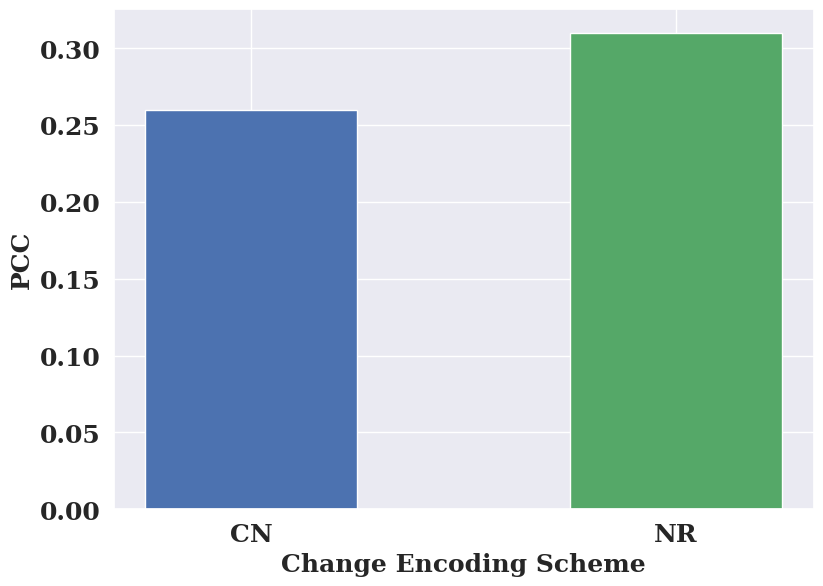

In [83]:
# Neighbor Embedding difference-norm feature section logic graph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.7)
# This d_1 will be created from PCC between S_2648_y and columns (71 and 73) of S_2648_X
PCC_ratio = round(pearsonr(S_2648_y,S_2648_X[:,71])[0],2)
PCC_diff =  round(pearsonr(S_2648_y,S_2648_X[:,73])[0],2)
print(PCC_ratio,PCC_diff) 

dpi_loc = 100
fig = plt.figure(figsize=(7, 5), dpi=dpi_loc)
ax = fig.add_axes([0,0,1,1])
# "CN" is the short form of Change-Norm 
methods = ['CN','NR']
vals = [PCC_ratio,PCC_diff]
plt.ylabel("PCC",fontsize=18,fontweight="bold",fontfamily="serif")
plt.xlabel("Change Encoding Scheme",fontsize=18,fontweight="bold",fontfamily="serif")
plt.xticks(fontsize=18,fontweight="bold",fontfamily="serif")
plt.yticks(fontsize=18,fontweight="bold",fontfamily="serif")
ax.bar(methods,vals,color="BG",width=0.5)
plt.show()

# fig = plt.figure(figsize=(6,4))
# ax = fig.add_axes([0,0,1,1])
# methods = ['PMPNN_DEP','PMPNN_ET','PMPNN_DEP_ET','PSSM_DEC','PMPNN_DEP_PSSM_DEC']
# vals = [0.34,0.26,0.34,0.18,0.36]
# plt.ylabel("Pearson Correlation",fontsize=18)
# plt.xlabel("Informative Features",fontsize=18)
# plt.xticks(fontsize=18, rotation=90)
# plt.yticks(fontsize=18)
# plt.ylim(0.10,0.40)
# ax.bar(methods,vals,color="maroon",width=0.3)
# plt.show()

0.15 0.03


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


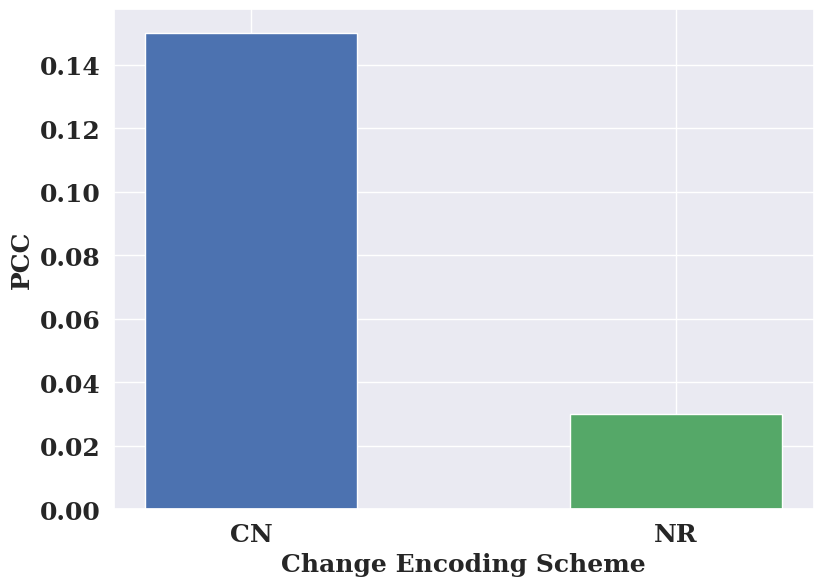

In [84]:
# Neighbor Embedding difference-norm feature section logic graph
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.7)
# This d_1 will be created from PCC between S_2648_y and columns (71 and 73) of S_2648_X
PCC_ratio = abs(round(pearsonr(S_2648_y,S_2648_X[:,72])[0],2))
PCC_diff =  abs(round(pearsonr(S_2648_y,S_2648_X[:,74])[0],2))
print(PCC_ratio,PCC_diff) 

dpi_loc = 100
fig = plt.figure(figsize=(7, 5), dpi=dpi_loc)
ax = fig.add_axes([0,0,1,1])
# "CN" is the short form of Change-Norm 
methods = ['CN','NR']
vals = [PCC_ratio,PCC_diff]
plt.ylabel("PCC",fontsize=18,fontweight="bold",fontfamily="serif")
plt.xlabel("Change Encoding Scheme",fontsize=18,fontweight="bold",fontfamily="serif")
plt.xticks(fontsize=18,fontweight="bold",fontfamily="serif")
plt.yticks(fontsize=18,fontweight="bold",fontfamily="serif")
ax.bar(methods,vals,color="BG",width=0.5)
plt.show()

In [ ]:
# Neighbor Message norm-ratio feature section logic graph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.7)
# This d_1 will be created from PCC between S_2648_y and columns (71 and 73) of S_2648_X
PCC_ratio = pearsonr(S_2648_y,S_2648_X[:,71])[0]
PCC_diff =  pearsonr(S_2648_y,S_2648_X[:,73])[0]
print(PCC_ratio,PCC_diff)

In [13]:
S_2648_X_aug = []
S_2648_y_aug = []
# the two variables below will help to take out the reverse-mutant PCA features out of X
n_pca_features = 5
n_kpca_features = 10
for i,(X,y) in enumerate(zip(S_2648_X,S_2648_y)):
    forward_X = []
    # adding non-pca features
    forward_X.extend(X[0:11])
    # adding neighbor-pca features
    forward_X.extend(X[11:16])
    # adding neighbor-kpca features
    forward_X.extend(X[16:26])
    # adding m_pca features
    forward_X.extend(X[41:46])
    # adding m_kpca features
    forward_X.extend(X[46:56])
    S_2648_X_aug.append(np.array(forward_X))

    # reverse-mutant addition START
    rev_X = np.zeros_like(S_2648_X_aug[-1])
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    rev_X[11:16] = X[26:31]
    rev_X[16:26] = X[31:41]
    rev_X[26:31] = X[56:61]
    rev_X[31:41] = X[61:71]
    S_2648_X_aug.append(rev_X)
    ### reverse addition END
    S_2648_y_aug.append(y)
    S_2648_y_aug.append(-1*y)
S_2648_X_aug = np.array(S_2648_X_aug)
S_2648_y_aug = np.array(S_2648_y_aug)

S_921_X_aug = []
S_921_y_aug = []
for i,(X,y) in enumerate(zip(S_921_X,S_921_y)):
    forward_X = []
    # adding non-pca features
    forward_X.extend(X[0:11])
    # adding neighbor-pca features
    forward_X.extend(X[11:16])
    # adding neighbor-kpca features
    forward_X.extend(X[16:26])
    # adding m_pca features
    forward_X.extend(X[41:46])
    # adding m_kpca features
    forward_X.extend(X[46:56])
    S_921_X_aug.append(np.array(forward_X))

    # reverse-mutant addition START
    rev_X = np.zeros_like(S_921_X_aug[-1])
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    rev_X[11:16] = X[26:31]
    rev_X[16:26] = X[31:41]
    rev_X[26:31] = X[56:61]
    rev_X[31:41] = X[61:71]
    S_921_X_aug.append(rev_X)
    ### reverse addition END
    S_921_y_aug.append(y)
    S_921_y_aug.append(-1*y)
S_921_X_aug = np.array(S_921_X_aug)
S_921_y_aug = np.array(S_921_y_aug)

S_669_X_aug = []
S_669_y_aug = []
for i,(X,y) in enumerate(zip(S_669_X,S_669_y)):
    forward_X = []
    # adding non-pca features
    forward_X.extend(X[0:11])
    # adding neighbor-pca features
    forward_X.extend(X[11:16])
    # adding neighbor-kpca features
    forward_X.extend(X[16:26])
    # adding m_pca features
    forward_X.extend(X[41:46])
    # adding m_kpca features
    forward_X.extend(X[46:56])
    S_669_X_aug.append(np.array(forward_X))

    # reverse-mutant addition START
    rev_X = np.zeros_like(S_669_X_aug[-1])
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    # adding neighbor-pca features
    rev_X[11:16] = X[26:31]
    # adding neighbor-kpca features
    rev_X[16:26] = X[31:41]
    # adding m_pca features
    rev_X[26:31] = X[56:61]
    # adding m_kpca features
    rev_X[31:41] = X[61:71]
    S_669_X_aug.append(rev_X)
    ### reverse addition END
    S_669_y_aug.append(y)
    S_669_y_aug.append(-1*y)
S_669_X_aug = np.array(S_669_X_aug)
S_669_y_aug = np.array(S_669_y_aug)

Ssym_X_aug = []
Ssym_y_aug = []
for i,(X,y) in enumerate(zip(Ssym_X,Ssym_y)):
    forward_X = []
    # adding non-pca features
    forward_X.extend(X[0:11])
    # adding neighbor-pca features
    forward_X.extend(X[11:16])
    # adding neighbor-kpca features
    forward_X.extend(X[16:26])
    # adding m_pca features
    forward_X.extend(X[41:46])
    # adding m_kpca features
    forward_X.extend(X[46:56])
    Ssym_X_aug.append(np.array(forward_X))

    # reverse-mutant addition START
    rev_X = np.zeros_like(Ssym_X_aug[-1])
    rev_X[0] =  -1*X[0]
    rev_X[1] =  X[1]
    rev_X[2] =  -1*X[2]
    rev_X[3] =  X[4]
    rev_X[4] =  X[3]
    rev_X[5] = -1*X[5]
    rev_X[6] = -1*X[6]
    rev_X[7] = 1/X[7]
    rev_X[8] = X[8]
    rev_X[9] = X[10]
    rev_X[10] = X[9]
    rev_X[11:16] = X[26:31]
    rev_X[16:26] = X[31:41]
    rev_X[26:31] = X[56:61]
    rev_X[31:41] = X[61:71]
    Ssym_X_aug.append(rev_X)
    ### reverse addition END
    Ssym_y_aug.append(y)
    Ssym_y_aug.append(-1*y)
Ssym_X_aug = np.array(Ssym_X_aug)
Ssym_y_aug = np.array(Ssym_y_aug)

In [15]:
# Now, traing linear regression on S_2648, and test on S_921 and S_669
# the setting reg = Ridge(alpha=0.2,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) seems quite good
# Ridge(alpha=0.25,normalize=True).fit(S_2648_X_aug[:,[0,2,4,5]], S_2648_y_aug) is also good
# Ridge(alpha=0,normalize=True) is also not bad
# (center_mut_wild_energy,weighted_neighbor_energy_changes,weighted_neighbor_backward_KL,PSSM) seems the best combination for now
# also, ridge with alpha=0.4 seems the best for now (specially, for S_669)
# also, ridge with alpha=0.9, and (center_mut_wild_energy,weighted_neighbor_backward_KL,PSSM) gets the maximum for S_669 while reducing for S_sym
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35]
used_features = [0,5,6,7,8,9,10,31,32,33,34,35]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35]
reg = Ridge(alpha=0,normalize=True,max_iter=5000000).fit(S_2648_X_aug[:,used_features], S_2648_y_aug)
print(pearsonr(S_2648_y_aug,reg.predict(S_2648_X_aug[:,used_features])))
print(pearsonr(S_921_y_aug[0::2],reg.predict(S_921_X_aug[0::2,used_features])))
print(pearsonr(S_669_y_aug,reg.predict(S_669_X_aug[:,used_features])))
print(pearsonr(Ssym_y_aug,reg.predict(Ssym_X_aug[:,used_features])))

(0.7511915304713476, 0.0)
(0.7188191834926682, 2.8860333630826e-147)
(0.6156843790185055, 5.354798052969183e-134)
(0.7316165115333608, 1.373463701993994e-115)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


In [16]:
print(reg.coef_)
print(reg.intercept_)

[ 0.27809452  0.01582197  0.00315951  0.00059364 -0.00411712  0.02602666
 -0.02607926  0.00441499  0.28133533 -0.00928265  0.1920253   0.00316145]
0.0944648492794847


In [19]:
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25]
# used_features = [0,5,6,7,8,9,10,20,16,17,18,19]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,21,22,23,24,25]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37,38,39,40]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37]
# used_features = [0,5,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35,36,37]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25]
# used_features = [0,4,5,6,7,8,9,10,31,32,33,34,35]
used_features = [0,2,5,6,7,8,9,10,31,32,33,34,35]
rf_5 = RandomForestRegressor(min_samples_split=2,n_estimators=500,max_samples=0.5,max_features="sqrt").fit(S_2648_X_aug[:,used_features],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,used_features])))
print(pearsonr(S_921_y,rf_5.predict(S_921_X_aug[0::2,used_features])))
print(pearsonr(S_669_y,rf_5.predict(S_669_X_aug[0::2,used_features])))
print(pearsonr(Ssym_y,rf_5.predict(Ssym_X_aug[0::2,used_features])))
rf_5.feature_importances_

(0.9367390389379499, 0.0)
(0.7717148877950495, 7.75902259221028e-183)
(0.47981065050612964, 4.804211320641724e-38)
(0.7274517063572093, 1.4366450679957317e-57)


array([0.22805729, 0.05767971, 0.10079997, 0.05656147, 0.11376665,
       0.06383039, 0.0637659 , 0.06621576, 0.0407944 , 0.07573701,
       0.0502563 , 0.04497403, 0.03756112])

In [20]:
used_features = [0,5,6,7,8,9,10,31,32,33,34,35]
rf_5 = RandomForestRegressor(min_samples_split=2,n_estimators=500,max_samples=0.5,max_features="sqrt").fit(S_2648_X_aug[:,used_features],S_2648_y_aug)
print(pearsonr(S_2648_y_aug,rf_5.predict(S_2648_X_aug[:,used_features])))
print(pearsonr(S_921_y,rf_5.predict(S_921_X_aug[0::2,used_features])))
print(pearsonr(S_669_y,rf_5.predict(S_669_X_aug[0::2,used_features])))
print(pearsonr(Ssym_y,rf_5.predict(Ssym_X_aug[0::2,used_features])))
rf_5.feature_importances_

(0.9354600459220591, 0.0)
(0.7674392002299467, 1.2975050625095755e-179)
(0.47736262641770233, 1.2692968045830674e-37)
(0.7202697454004424, 5.947503161867698e-56)


array([0.22643209, 0.1121636 , 0.06008392, 0.12454218, 0.07199351,
       0.06649929, 0.0664911 , 0.04512027, 0.08029545, 0.05435771,
       0.04943027, 0.04259062])

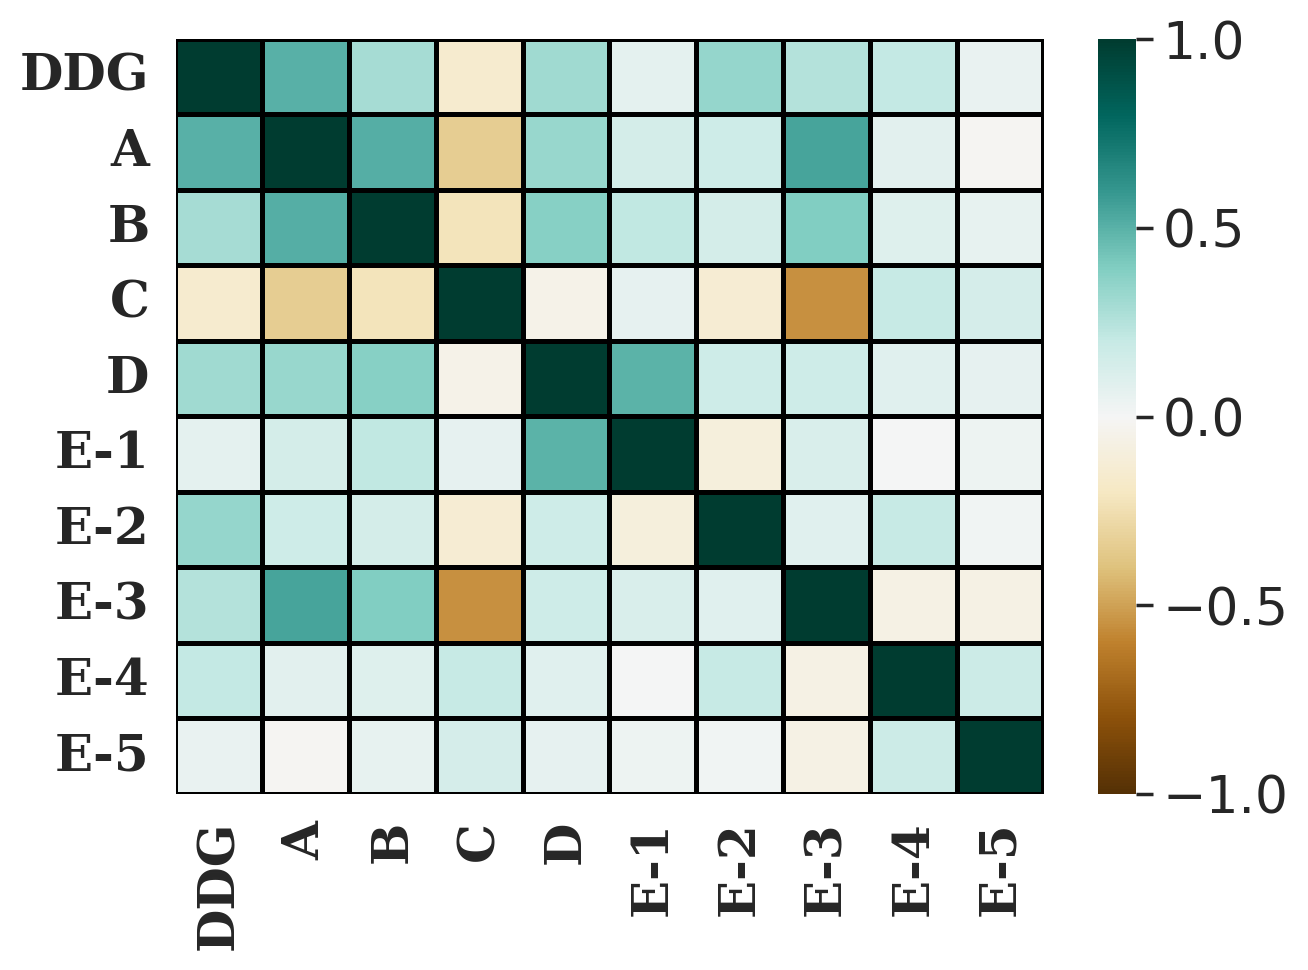

<Figure size 432x288 with 0 Axes>

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


used_features = [0,5,6,7,8,9,10,31,32,33,34,35]

df_S_2648 = pd.DataFrame(

    {'DDG' : S_2648_y_aug[0::2],
     'A': S_2648_X_aug[0::2,0],
    #  'P_DEC': Ssym_X[0::2,5],
     'B' : S_2648_X_aug[0::2,6],
     'C' : S_2648_X_aug[0::2,7],
     'D' : S_2648_X_aug[0::2,8],
    #  'pssm_wild' : Ssym_X[0::2,9],
    #  'pssm_alternate' : Ssym_X[0::2,10],
     'E-1' : S_2648_X_aug[0::2,31],
     'E-2' : S_2648_X_aug[0::2,32],
     'E-3' : S_2648_X_aug[0::2,33],
     'E-4' : S_2648_X_aug[0::2,34],
     'E-5' : S_2648_X_aug[0::2,35] 
    })
corr = df_S_2648.corr()

sns.set(font_scale=1.7)
dpi_loc = 200
plt.figure(figsize=(7, 5), dpi=dpi_loc)
g = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        linewidths=1.5,
        linecolor='black',
        cmap="BrBG",
        vmax=1.0,
        vmin=-1.0)
g.set_yticklabels(g.get_yticklabels(),rotation=0,fontsize=18,fontweight="bold",fontfamily="serif")
g.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=18,fontweight="bold",fontfamily="serif")
plt.show()
plt.savefig("Feature-Feature_Correlation.png",dpi=dpi_loc)

In [32]:
corr

,DDG,A,B,C,D,E-1,E-2,E-3,E-4,E-5
DDG,1.000000,0.506653,0.291537,-0.150304,0.308701,0.073913,0.336660,0.256269,0.204877,0.047127
A,0.506653,1.000000,0.514658,-0.340462,0.331952,0.141369,0.165718,0.547897,0.078585,-0.011028
B,0.291537,0.514658,1.000000,-0.223649,0.382440,0.212651,0.141593,0.398010,0.095755,0.058331
C,-0.150304,-0.340462,-0.223649,1.000000,-0.047038,0.067300,-0.136257,-0.547894,0.201958,0.137475
D,0.308701,0.331952,0.382440,-0.047038,1.000000,0.492633,0.171205,0.169664,0.088050,0.068704
E-1,0.073913,0.141369,0.212651,0.067300,0.492633,1.000000,-0.095221,0.118914,0.004878,0.032526
E-2,0.336660,0.165718,0.141593,-0.136257,0.171205,-0.095221,1.000000,0.089578,0.197473,0.020172
E-3,0.256269,0.547897,0.398010,-0.547894,0.169664,0.118914,0.089578,1.000000,-0.066716,-0.063130
E-4,0.204877,0.078585,0.095755,0.201958,0.088050,0.004878,0.197473,-0.066716,1.000000,0.174738
E-5,0.047127,-0.011028,0.058331,0.137475,0.068704,0.032526,0.020172,-0.063130,0.174738,1.000000


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


used_features = [0,5,6,7,8,9,10,31,32,33,34,35]

df_Ssym = pd.DataFrame(

    {'DDG' : Ssym_y[0::2],
     'P_DP': Ssym_X[0::2,0],
     'P_DEC': Ssym_X[0::2,5],
     'Neighbor_Entropy_Change' : Ssym_X[0::2,6],
     'neighbor_attention_change_w/m' : Ssym_X[0::2,7],
     'neighbor_embedding_change' : Ssym_X[0::2,8],
     'pssm_wild' : Ssym_X[0::2,9],
     'pssm_alternate' : Ssym_X[0::2,10],
     'pca-1' : Ssym_X[0::2,31],
     'pca-2' : Ssym_X[0::2,32],
     'pca-3' : Ssym_X[0::2,33],
     'pca-4' : Ssym_X[0::2,34],
     'pca-5' : Ssym_X[0::2,35] 
    })
corr = df_Ssym.corr()

sns.set(font_scale=1.4)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap="PuOr")
plt.show()

NameError: ignored

In [76]:
import math
# # adding neighbor-pca features
#     rev_X[11:16] = X[26:31]
#     # adding neighbor-kpca features
#     rev_X[16:26] = X[31:41]
#     # adding m_pca features
#     rev_X[26:31] = X[56:61]
#     # adding m_kpca features
#     rev_X[31:41] = X[61:71]
    
# This is so fucking good, I love it
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,21,22,23,24,25]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37,38,39,40]
# used_features = [0,2,4,5,6,7,8,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37]
# used_features = [0,5,9,10,20,16,17,18,19,11,12,13,14,15,21,22,23,24,25,26,31,32,33,34,35,36,37]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25,31,32,33,34,35,36,37,38,39,40]
# used_features = [0,2,4,5,6,7,8,9,10,16,17,18,19,20,21,22,23,24,25]
# used_features = [0,2,4,5,6,7,8,9,10,31,32,33,34,35]
# used_features = [0,2,4,5,6,7,8,9,10,31,32,33,34,35]
# used_features = [0,2,5,6,7,8,9,10,31,32,33,34,35]
# used_features = [0,5,6,7,8,9,10,31,32,33,34,35]
used_features = [0,5,6,7,8,9,10,31,32,33,34,35]
rf_5 = RandomForestRegressor(min_samples_split=2,n_estimators=500,max_samples=0.5,max_features="sqrt").fit(S_2648_X_aug[:,used_features],S_2648_y_aug[:])
S_2648_aug_preds = rf_5.predict(S_2648_X_aug[:,used_features])
S_921_aug_preds = rf_5.predict(S_921_X_aug[:,used_features])
S_669_aug_preds = rf_5.predict(S_669_X_aug[:,used_features])
Ssym_aug_preds = rf_5.predict(Ssym_X_aug[:,used_features])
# print(pearsonr(S_2648_y_aug,S_2648_aug_preds))
# print(pearsonr(S_2648_y_aug[0::2],S_2648_aug_preds[0::2]))
# print(pearsonr(S_2648_y_aug[1::2],S_2648_aug_preds[1::2]))
print(pearsonr(S_921_y_aug,S_921_aug_preds))
print(pearsonr(S_921_y_aug[0::2],S_921_aug_preds[0::2]))
print(pearsonr(S_921_y_aug[1::2],S_921_aug_preds[1::2]))
print(pearsonr(S_669_y_aug,S_669_aug_preds))
print(pearsonr(S_669_y_aug[0::2],S_669_aug_preds[0::2]))
print(pearsonr(S_669_y_aug[1::2],S_669_aug_preds[1::2]))
print(pearsonr(Ssym_y_aug,Ssym_aug_preds))
print(pearsonr(Ssym_y_aug[0::2],Ssym_aug_preds[0::2]))
print(pearsonr(Ssym_y_aug[1::2],Ssym_aug_preds[1::2]))

print(math.sqrt(((S_921_y_aug-S_921_aug_preds)**2).mean()))
print(math.sqrt(((S_921_y_aug[1::2]-S_921_aug_preds[1::2])**2).mean()))
print(math.sqrt(((S_921_y_aug[0::2]-S_921_aug_preds[0::2])**2).mean()))

print(math.sqrt(((S_669_y_aug-S_669_aug_preds)**2).mean()))
print(math.sqrt(((S_669_y_aug[1::2]-S_669_aug_preds[1::2])**2).mean()))
print(math.sqrt(((S_669_y_aug[0::2]-S_669_aug_preds[0::2])**2).mean()))

print(math.sqrt(((Ssym_y_aug-Ssym_aug_preds)**2).mean()))
print(math.sqrt(((Ssym_y_aug[1::2]-Ssym_aug_preds[1::2])**2).mean()))
print(math.sqrt(((Ssym_y_aug[0::2]-Ssym_aug_preds[0::2])**2).mean()))


rf_5.feature_importances_

(0.7951054559001914, 0.0)
(0.7675665691904682, 1.0425421922285914e-179)
(0.7691868029071044, 6.369144375667188e-181)
(0.643304272799088, 5.841115915467813e-150)
(0.48122025849130307, 2.73596065678241e-38)
(0.4753247385150954, 2.8328276613324236e-37)
(0.8124495230466188, 5.980557836154855e-162)
(0.7238214323884201, 9.573830318916375e-57)
(0.7181928704994552, 1.708115513185573e-55)
1.4915335516917998
1.4907393676939005
1.492327313042383
1.453372497062347
1.4559280249935969
1.4508124677134284
1.1003721524479986
1.1039739722904418
1.096758504079793


array([0.2416164 , 0.09850827, 0.0583405 , 0.1270614 , 0.072926  ,
       0.06839639, 0.06501885, 0.04437698, 0.08053017, 0.05217366,
       0.04963963, 0.04141176])

In [77]:
feature_to_index_map = {"A":0,
                        "B":6,
                        "C":7,
                        "D":8,
                        "E":[31,32,33,34,35],
                        "F":5,
                        "G":9,
                        "H":10}
# In the "results_tracking_dict" below, outer-level keys will be dataset names, and values will be dictionaries
results_tracking_dict = {}
# In the inner dictionaries, keys will be feature-name alphabet representations separated by (+) between them, and values will be pearson correlations on both "direct" and "reverse" mutations
results_tracking_dict["S_2648_total_PCC"] = {}
results_tracking_dict["S_2648_direct_PCC"] = {}
results_tracking_dict["S_2648_reverse_PCC"] = {}
results_tracking_dict["S_2648_total_RMSE"] = {}
results_tracking_dict["S_2648_direct_RMSE"] = {}
results_tracking_dict["S_2648_reverse_RMSE"] = {} 
results_tracking_dict["S_921_total_PCC"] = {}
results_tracking_dict["S_921_direct_PCC"] = {}
results_tracking_dict["S_921_reverse_PCC"] = {}
results_tracking_dict["S_921_total_RMSE"] = {}
results_tracking_dict["S_921_direct_RMSE"] = {}
results_tracking_dict["S_921_reverse_RMSE"] = {}
results_tracking_dict["S_669_total_PCC"] = {}
results_tracking_dict["S_669_direct_PCC"] = {}
results_tracking_dict["S_669_reverse_PCC"] = {}
results_tracking_dict["S_669_total_RMSE"] = {}
results_tracking_dict["S_669_direct_RMSE"] = {}
results_tracking_dict["S_669_reverse_RMSE"] = {}
results_tracking_dict["Ssym_total_PCC"] = {}
results_tracking_dict["Ssym_direct_PCC"] = {}
results_tracking_dict["Ssym_reverse_PCC"] = {}
results_tracking_dict["Ssym_total_RMSE"] = {}
results_tracking_dict["Ssym_direct_RMSE"] = {}
results_tracking_dict["Ssym_reverse_RMSE"] = {}
# In the "model_tracking_dict" below, keys will be feature-name alphabet representations separated by (+) between them, and values will be RF
# trained with the corresponding feature combination on S_2648 dataset  
model_tracking_dict = {}
feature_combinations = [("A"),("A","B"),("A","B","C"),("A","B","C","D"),("A","B","C","D","E"),("A","B","C","D","E","F"),("A","B","C","D","E","F","G"),("A","B","C","D","E","F","G","H")]

for f_comb in feature_combinations:
    f_index_comb = []
    for i in f_comb:
        if isinstance(feature_to_index_map[i],list):
            f_index_comb.extend(feature_to_index_map[i])
        else:
            f_index_comb.append(feature_to_index_map[i]) 
    inner_key = str(["+".join([i for i in f_comb])][0])

    loc_rf = RandomForestRegressor(min_samples_split=2,n_estimators=500,max_samples=0.5,max_features="sqrt").fit(S_2648_X_aug[:,f_index_comb],S_2648_y_aug)

    S_2648_aug_preds = loc_rf.predict(S_2648_X_aug[:,f_index_comb])
    results_tracking_dict["S_2648_total_PCC"][inner_key] = pearsonr(S_2648_y_aug,S_2648_aug_preds)[0]
    results_tracking_dict["S_2648_direct_PCC"][inner_key] = pearsonr(S_2648_y_aug[0::2],S_2648_aug_preds[0::2])[0] 
    results_tracking_dict["S_2648_reverse_PCC"][inner_key] = pearsonr(S_2648_y_aug[1::2],S_2648_aug_preds[1::2])[0]
    results_tracking_dict["S_2648_total_RMSE"][inner_key] = math.sqrt(((S_2648_y_aug-S_2648_aug_preds)**2).mean()) 
    results_tracking_dict["S_2648_direct_RMSE"][inner_key] = math.sqrt(((S_2648_y_aug[0::2]-S_2648_aug_preds[0::2])**2).mean()) 
    results_tracking_dict["S_2648_reverse_RMSE"][inner_key] = math.sqrt(((S_2648_y_aug[1::2]-S_2648_aug_preds[1::2])**2).mean())

    S_921_aug_preds = loc_rf.predict(S_921_X_aug[:,f_index_comb])
    results_tracking_dict["S_921_total_PCC"][inner_key] = pearsonr(S_921_y_aug,S_921_aug_preds)[0]
    results_tracking_dict["S_921_direct_PCC"][inner_key] = pearsonr(S_921_y_aug[0::2],S_921_aug_preds[0::2])[0] 
    results_tracking_dict["S_921_reverse_PCC"][inner_key] = pearsonr(S_921_y_aug[1::2],S_921_aug_preds[1::2])[0]
    results_tracking_dict["S_921_total_RMSE"][inner_key] = math.sqrt(((S_921_y_aug-S_921_aug_preds)**2).mean()) 
    results_tracking_dict["S_921_direct_RMSE"][inner_key] = math.sqrt(((S_921_y_aug[0::2]-S_921_aug_preds[0::2])**2).mean()) 
    results_tracking_dict["S_921_reverse_RMSE"][inner_key] = math.sqrt(((S_921_y_aug[1::2]-S_921_aug_preds[1::2])**2).mean())

    S_669_aug_preds = loc_rf.predict(S_669_X_aug[:,f_index_comb])
    results_tracking_dict["S_669_total_PCC"][inner_key] = pearsonr(S_669_y_aug,S_669_aug_preds)[0]
    results_tracking_dict["S_669_direct_PCC"][inner_key] = pearsonr(S_669_y_aug[0::2],S_669_aug_preds[0::2])[0] 
    results_tracking_dict["S_669_reverse_PCC"][inner_key] = pearsonr(S_669_y_aug[1::2],S_669_aug_preds[1::2])[0]
    results_tracking_dict["S_669_total_RMSE"][inner_key] = math.sqrt(((S_669_y_aug-S_669_aug_preds)**2).mean()) 
    results_tracking_dict["S_669_direct_RMSE"][inner_key] = math.sqrt(((S_669_y_aug[0::2]-S_669_aug_preds[0::2])**2).mean()) 
    results_tracking_dict["S_669_reverse_RMSE"][inner_key] = math.sqrt(((S_669_y_aug[1::2]-S_669_aug_preds[1::2])**2).mean())


    Ssym_aug_preds = loc_rf.predict(Ssym_X_aug[:,f_index_comb])
    results_tracking_dict["Ssym_total_PCC"][inner_key] = pearsonr(Ssym_y_aug,Ssym_aug_preds)[0]
    results_tracking_dict["Ssym_direct_PCC"][inner_key] = pearsonr(Ssym_y_aug[0::2],Ssym_aug_preds[0::2])[0] 
    results_tracking_dict["Ssym_reverse_PCC"][inner_key] = pearsonr(Ssym_y_aug[1::2],Ssym_aug_preds[1::2])[0]
    results_tracking_dict["Ssym_total_RMSE"][inner_key] = math.sqrt(((Ssym_y_aug-Ssym_aug_preds)**2).mean()) 
    results_tracking_dict["Ssym_direct_RMSE"][inner_key] = math.sqrt(((Ssym_y_aug[0::2]-Ssym_aug_preds[0::2])**2).mean()) 
    results_tracking_dict["Ssym_reverse_RMSE"][inner_key] = math.sqrt(((Ssym_y_aug[1::2]-Ssym_aug_preds[1::2])**2).mean())

    model_tracking_dict[inner_key] = loc_rf

In [78]:
print(results_tracking_dict["S_2648_total_PCC"])
print(results_tracking_dict["S_2648_total_RMSE"])

{'A': 0.8829334516693577, 'A+B': 0.9036086231810785, 'A+B+C': 0.9119422222441689, 'A+B+C+D': 0.9173010025827986, 'A+B+C+D+E': 0.9331357789688524, 'A+B+C+D+E+F': 0.934501129983057, 'A+B+C+D+E+F+G': 0.9353303941990047, 'A+B+C+D+E+F+G+H': 0.9357657864443959}
{'A': 0.8588437047435545, 'A+B': 0.8023860445132496, 'A+B+C': 0.7765624192985355, 'A+B+C+D': 0.7541788719604942, 'A+B+C+D+E': 0.6878226501055112, 'A+B+C+D+E+F': 0.6808245643918215, 'A+B+C+D+E+F+G': 0.6782247663455709, 'A+B+C+D+E+F+G+H': 0.6766744490478409}


In [79]:
print(results_tracking_dict["Ssym_total_PCC"])
print(results_tracking_dict["Ssym_total_RMSE"])

{'A': 0.6406883983806305, 'A+B': 0.703328899285716, 'A+B+C': 0.7156668725249671, 'A+B+C+D': 0.7426311499774217, 'A+B+C+D+E': 0.7864864559993356, 'A+B+C+D+E+F': 0.8022714815856546, 'A+B+C+D+E+F+G': 0.8076551682707677, 'A+B+C+D+E+F+G+H': 0.8118413491812798}
{'A': 1.4577634163117281, 'A+B': 1.3190223681759676, 'A+B+C': 1.2946304581479333, 'A+B+C+D': 1.2413275467370823, 'A+B+C+D+E': 1.149098669093934, 'A+B+C+D+E+F': 1.1202025429969538, 'A+B+C+D+E+F+G': 1.1095128183329066, 'A+B+C+D+E+F+G+H': 1.1009631892102054}


In [80]:
print(results_tracking_dict["S_669_total_PCC"])
print(results_tracking_dict["S_669_total_RMSE"])

{'A': 0.47302115619256135, 'A+B': 0.5290936877469211, 'A+B+C': 0.5780420385234404, 'A+B+C+D': 0.6019520209475583, 'A+B+C+D+E': 0.638329794136528, 'A+B+C+D+E+F': 0.6450164390214402, 'A+B+C+D+E+F+G': 0.641893515285423, 'A+B+C+D+E+F+G+H': 0.6430993657984322}
{'A': 1.7180226581396387, 'A+B': 1.622093085662447, 'A+B+C': 1.550904655061736, 'A+B+C+D': 1.517030309760789, 'A+B+C+D+E': 1.4609304764114674, 'A+B+C+D+E+F': 1.4502780531733563, 'A+B+C+D+E+F+G': 1.455379405219905, 'A+B+C+D+E+F+G+H': 1.4536663191803803}


In [81]:
print(results_tracking_dict["S_921_total_PCC"])
print(results_tracking_dict["S_921_total_RMSE"])

{'A': 0.6491692364011791, 'A+B': 0.7010416806431414, 'A+B+C': 0.6985722039227716, 'A+B+C+D': 0.7309833780042638, 'A+B+C+D+E': 0.7591257504398808, 'A+B+C+D+E+F': 0.7877844523677066, 'A+B+C+D+E+F+G': 0.7909039290080782, 'A+B+C+D+E+F+G+H': 0.7933838787511099}
{'A': 1.7723210451554892, 'A+B': 1.6761911547937893, 'A+B+C': 1.6902896414012545, 'A+B+C+D': 1.618830967959764, 'A+B+C+D+E': 1.5632951746953059, 'A+B+C+D+E+F': 1.506837878502324, 'A+B+C+D+E+F+G': 1.5007959951069874, 'A+B+C+D+E+F+G+H': 1.494635227345916}


In [ ]:
# import pickle
# with open("incremental_feature_result_dict.pickle","wb") as f:
#     pickle.dump(results_tracking_dict,f)

In [ ]:
# import pickle
# with open("incremental_feature_result_dict.pickle","rb") as f:
#     results_tracking_dict = pickle.load(f)

In [ ]:
S_921_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_921'],orient="index",columns=["PCC"])
S_921_dataframe = S_921_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
# S_921_dataframe["combo_length"] = [len(i) for i in list(S_921_dataframe.index)]
# S_921_dataframe["combo_signature"] = [i for i in list(S_921_dataframe.index)]
# # print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
# max_idx = (S_921_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_921_dataframe["PCC"])
# S_921_max_results = S_921_dataframe[max_idx]
S_921_max_results

,PCC,combo_length,combo_signature
A,0.688,1,A
A+D,0.732,3,A+D
A+E+F,0.749,5,A+E+F
A+D+E+F,0.763,7,A+D+E+F
A+B+D+E+F,0.757,9,A+B+D+E+F
A+B+C+D+E+F,0.749,11,A+B+C+D+E+F


In [ ]:
S_669_dataframe = pd.DataFrame.from_dict(results_tracking_dict['S_669'],orient="index",columns=["PCC"])
S_669_dataframe = S_669_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
S_669_dataframe["combo_length"] = [len(i) for i in list(S_669_dataframe.index)]
S_669_dataframe["combo_signature"] = [i for i in list(S_669_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (S_669_dataframe.groupby(["combo_length"])["PCC"].transform(max) == S_669_dataframe["PCC"])
S_669_max_results = S_669_dataframe[max_idx]
S_669_max_results 

,PCC,combo_length,combo_signature
A,0.542,1,A
A+B,0.582,3,A+B
A+B+C,0.594,5,A+B+C
A+B+F,0.594,5,A+B+F
A+B+C+F,0.603,7,A+B+C+F
A+B+C+E+F,0.601,9,A+B+C+E+F
A+B+C+D+E+F,0.596,11,A+B+C+D+E+F


In [ ]:
Ssym_dataframe = pd.DataFrame.from_dict(results_tracking_dict['Ssym'],orient="index",columns=["PCC"])
Ssym_dataframe = Ssym_dataframe.round(decimals=3)
# now, create another dataframe from "S_921_dataframe" called "S_921_dataframe_reduced",
# where the rows containing max vals among 1,2,3,4,5, and 6 combos will be saved
# as a result, this reduced dataframe will contain only 6 rows
# create a new column in the dataframe containing the length of the repsective index values
# then we can group by this column, and then take the max from each group to get the desired reduced dataFrame  
# for index, row in S_921_dataframe.iterrows():
#     # print(row["PCC"])
#     print(len(index))
# what the fuck is wrong with the index vals?
# why the fuck have the feature names been swapped in some godforsaken weird way?
Ssym_dataframe["combo_length"] = [len(i) for i in list(Ssym_dataframe.index)]
Ssym_dataframe["combo_signature"] = [i for i in list(Ssym_dataframe.index)]
# print(S_921_dataframe.loc(S_921_dataframe.groupby(["combo_length"]).idxmax()))
max_idx = (Ssym_dataframe.groupby(["combo_length"])["PCC"].transform(max) == Ssym_dataframe["PCC"])
Ssym_max_results = Ssym_dataframe[max_idx]
Ssym_max_results 

,PCC,combo_length,combo_signature
A,0.704,1,A
A+B,0.742,3,A+B
A+B+F,0.750,5,A+B+F
A+C+D,0.750,5,A+C+D
A+B+E+F,0.759,7,A+B+E+F
A+B+D+E+F,0.761,9,A+B+D+E+F
A+B+C+D+E+F,0.763,11,A+B+C+D+E+F
